# QC script to calculate sharpness metric for images in a plate

The following script takes an image from the IDR, adds increasing levels of blurriness to it and then calculates a 'sharpness' score for the images. 

It highlights the start of an investigation for a workflow that might be used to identify out-of-focus images across a plate of images.


# Workflow summary

![Overview](../../includes/SharpnessWorkflow.jpg)

### Import Packages that we will need later

In [13]:
from PIL import Image
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import decimal
import seaborn as sns
from mpl_toolkits.axes_grid1 import AxesGrid
from numpy import array, int8
from skimage import feature
import scipy as sp
from scipy.ndimage import convolve
from scipy import misc, fftpack
from scipy import ndimage
from idr.widgets import dropdown_widget
from idr import connection

### Create a connection to the IDR

In [14]:
conn = connection()

Connected to IDR...


### Define the 3 algorithms we are going to test
<br>
The algorithms were sourced from:

* gradientBased - [stackoverflow: Detect which image is sharper](https://stackoverflow.com/questions/6646371/detect-which-image-is-sharper/26014796)
* fourierBased - [Image Sharpness Measure for Blurred Images in Frequency Domain](https://doi.org/10.1016/j.proeng.2013.09.086)
* edgeBased - written by Balaji Ramalingan in Open Microscopy Environment team

In [15]:
class AlgorithmList:
    def gradientBasedSharpnessMetric(self):
        gy, gx = np.gradient(plane)
        gnorm = np.sqrt(gx**2 + gy**2)
        sharpness = np.average(gnorm)
        return sharpness
    def fourierBasedSharpnessMetric(self):
        fftimage = np.fft.fft2(plane)
        fftshift = np.fft.fftshift(fftimage)
        fftshift = np.absolute(fftshift)
        M = np.amax(fftshift)
        Th = (fftshift > (M/float(1000))).sum()
        if 'image' in locals():
            sharpness = Th/(float(image.getSizeX())*float(image.getSizeY()))
            return sharpness*10000
        else:
            return Th
    def edgeBasedSharpnessMetric(self):
        edges1 = feature.canny(plane, sigma=3)
        kernel = np.ones((3, 3))
        kernel[1, 1] = 0
        sharpness = convolve(edges1, kernel, mode="constant")
        sharpness = sharpness[edges1 != 0].sum()
        return sharpness
print "loaded:", dir(AlgorithmList)

loaded: ['__doc__', '__module__', 'edgeBasedSharpnessMetric', 'fourierBasedSharpnessMetric', 'gradientBasedSharpnessMetric']


### Choose which algorithm we are going to test

In [32]:
Algorithm = dropdown_widget(
    ['Gradient', 'Fourier', 'Edge'],
    'Algorithm: ', True
)

# SELECT THE METHOD THEN MOVE TO THE NEXT CELL WITHOUT RUNNING THE CELL AGAIN

A Jupyter Widget

### Then retrieve an image from the IDR
http://idr.openmicroscopy.org/webclient/?show=image-223958

In [37]:
imageId = 223958
image = conn.getObject("Image", imageId)
print image.getName(), image.getDescription()

plate1_2_006 [Well 25, Field 1 (Spot 25)] 


### Now create increasing levels of Gaussian blur on this image, and calculate the sharpness of the original and blurred images using the chosen algorithm

In [38]:
method = Algorithm.value
if method == 'Gradient':
    sharpness_method = AlgorithmList().gradientBasedSharpnessMetric
elif method == 'Fourier':
    sharpness_method = AlgorithmList().fourierBasedSharpnessMetric
elif method == 'Edge':
    sharpness_method = AlgorithmList().edgeBasedSharpnessMetric

pixels = image.getPrimaryPixels()
image_plane = pixels.getPlane(0, 0, 0)

resultArray = np.zeros((5, 2), dtype=float);
plt.figure(figsize=(20, 15))
cntr = 1
for sigValue in xrange(0,20,4):
    face = misc.face(gray=True)
    plane = ndimage.gaussian_filter(image_plane, sigma=sigValue)
    plt.subplot(1,5,cntr)
    plt.imshow(plane, cmap=plt.cm.gray)
    plt.axis('off')
    sharpness = sharpness_method()
    resultArray[cntr-1,1] = sharpness
    resultArray[cntr-1,0] = sigValue
    cntr = cntr + 1
    

### Show the images with increasing levels of blur

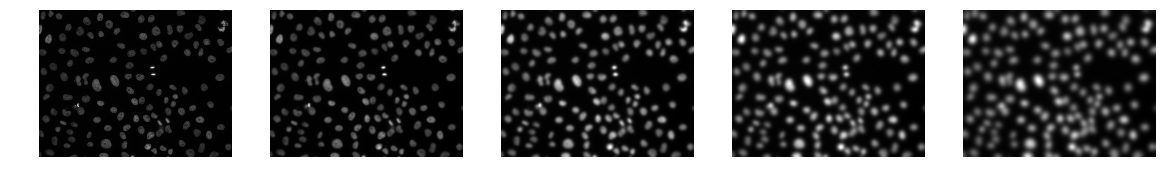

In [39]:
plt.show()

### Finally plot the Sharpness Score against the level of Gaussian blur

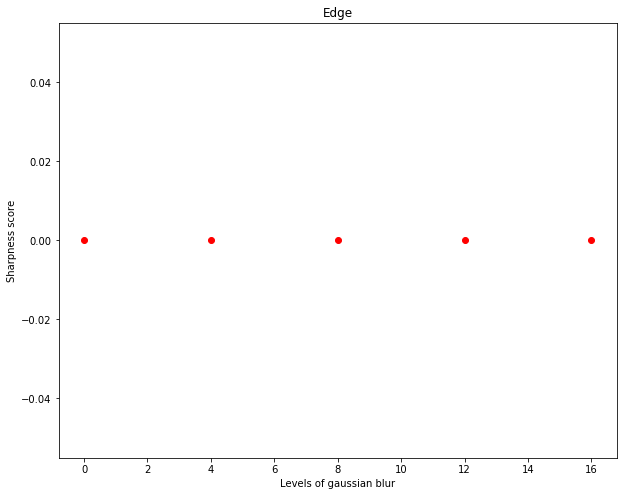

In [40]:
plt.figure(figsize=(10, 8))
plt.plot(resultArray[:,0], resultArray[:,1], 'ro')
plt.title(method)
plt.xlabel('Levels of gaussian blur')
plt.ylabel('Sharpness score')
plt.show()
plt.gcf().clear() 

### <span style="color:blue">How well did the sharpness algorithm perform?  Try another algorithm to see if it performs better.</span>

<br>
#### When you are completely finished running the notebook close the connection to IDR

In [36]:
conn.close()

This notebook is modified from the CalculateSharpness notebook created by Balaji Ramalingam